## Introduction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Cleaning and Preprocessing

In [2]:
# Import datasets
pitching_ratio = pd.read_csv('Pitching Data/Pitching Ratio.csv')
standard_pitching = pd.read_csv('Pitching Data/Standard Pitching.csv')
win_probability = pd.read_csv('Pitching Data/Win Probability.csv')
pitches = pd.read_csv('Pitching Data/Pitches.csv')

In [3]:
# Merge datasets
cols = pitching_ratio.columns.difference(standard_pitching.columns)
df = pd.merge(standard_pitching, pitching_ratio[cols], left_index = True, right_index = True)

cols = win_probability.columns.difference(df.columns)
df = pd.merge(df, win_probability[cols], left_index = True, right_index = True)

cols = pitches.columns.difference(df.columns)
df = pd.merge(df, pitches[cols], left_index = True, right_index = True)

In [4]:
# Select a subset of data to run analysis, drop missing data and irrelevant columns
# rename some columns for clarification
df = df[~df.isnull().any(axis = 1)]
df = df.drop(columns = ['Rk'])
df = df.rename(columns = {'Lg': 'League', 'Tm': 'Team'})

In [5]:
# Define categories for classification
df['Pitcher Role'] = df['GS'].apply(lambda x: 'Starter' if x >= 10 else 'Non-Starter')
df.head()

,Name,Age,Team,League,GS,W,L,W-L%,ERA,IP,...,Con,F/Str,I/Bll,I/Str,L/SO%,L/Str,Pit/PA,S/Str,Str%,Pitcher Role
0,Fernando Abad*\abadfe01,33,SFG,NL,0,0,2,0.000,4.15,13.0,...,73.90%,12.60%,0.00%,33.30%,66.70%,37.80%,3.49,16.20%,64.90%,Non-Starter
2,Jason Adam\adamja01,27,TOR,AL,0,3,0,1.000,2.91,21.2,...,71.90%,29.70%,0.00%,26.20%,27.80%,22.30%,4.36,21.80%,57.70%,Non-Starter
4,Austin Adams\adamsau02,28,TOT,MLB,2,2,2,0.500,3.94,32.0,...,59.80%,24.60%,0.00%,17.80%,26.40%,29.10%,4.16,28.50%,62.30%,Non-Starter
5,Chance Adams\adamsch01,24,NYY,AL,0,1,1,0.500,8.53,25.1,...,81.90%,33.90%,0.00%,28.10%,30.40%,24.30%,4.19,13.70%,60.30%,Non-Starter
7,Dario Agrazal\agrazda01,24,PIT,NL,14,4,5,0.444,4.91,73.1,...,84.10%,25.70%,0.00%,33.90%,43.90%,29.10%,3.58,11.30%,64.70%,Starter


In [6]:
# Split data set into numeric and categorical data
player = df[['Name', 'Team', 'League', 'Age', 'Pitcher Role']]
pitching = df.drop(['Name', 'Team', 'League', 'Age', 'IP', 'GS', 'Pitcher Role'], axis = 1)

In [7]:
# Convert percentage info into float
for col in pitching.columns:
    if pitching[col].dtypes == 'O':
        pitching[col] = pitching[col].apply(lambda x: float(x.strip('%')) / 100)

## Principal Component Analysis

In [8]:
# Normalize data
def normalize(lst):
    mean = np.mean(lst)
    return [(x - mean) / np.sqrt(len(lst)) for x in lst]
normalized_pitching = pitching.apply(normalize)
normalized_pitching = normalized_pitching.T

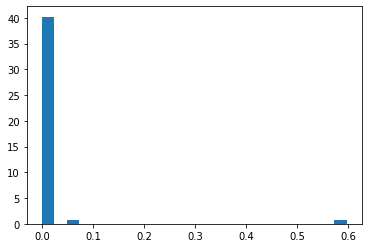

In [9]:
# Look at distribution of eigenvalues of the sample covariance matrix
m, N = normalized_pitching.shape
C = 1/N * normalized_pitching @ normalized_pitching.T
eigvals, eigvecs = np.linalg.eig(C) 
plt.hist(eigvals, density = True, bins  = 25)
plt.show()

In [10]:
# Decide an appropriate dimension and run PCA
u, s, vt = np.linalg.svd(normalized_pitching, full_matrices = False)
Q = u[:, np.array((0, 1))]
mu = pitching.mean(axis = 0).to_numpy()
mu.shape = (mu.size, 1)

In [11]:
# Project data set onto principal components
beta_2d = (1/np.sqrt(N) * Q.T @ normalized_pitching).to_numpy()
beta_bar = Q.T @ mu
pitching_2d = beta_2d + beta_bar

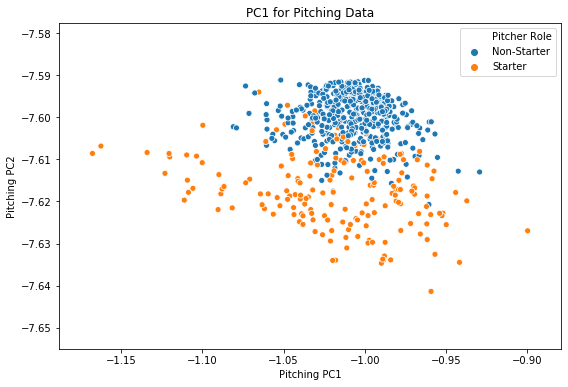

In [12]:
# Plot the projected data, hued by Pitcher Role (Starter vs. Non-Starter)
plt.figure(figsize = (9, 6))
plt.title("PC1 for Pitching Data")
plt.xlabel("Pitching PC1")
plt.ylabel("Pitching PC2")
sns.scatterplot(x = pitching_2d[0, :], y = pitching_2d[1, :], hue = player['Pitcher Role'])

## Logistic Regression after PCA

## Conclusion